### Import packages

In [155]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, r2_score

import json
import seaborn as sns
import matplotlib.pyplot as plt

### Load Data

In [104]:
def load_fx_data(file_path):
    df = pd.read_csv(file_path)
    df.drop(columns=['Vol.'], inplace=True, errors='ignore')

    # Clean column names
    df.columns = [col.replace(' %', '') for col in df.columns]

    # Parse dates
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
    df = df.sort_values('Date').reset_index(drop=True)

    # Convert numeric columns
    for col in ['Price', 'Open', 'High', 'Low']:
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', ''), errors='coerce')

    df['Change'] = df['Change'].str.rstrip('%').astype(float) / 100.0

    df.dropna(inplace=True)
    return df

In [144]:
file_path = "USD_JPY.csv"
df_main = load_fx_data(file_path)

### Visualize data

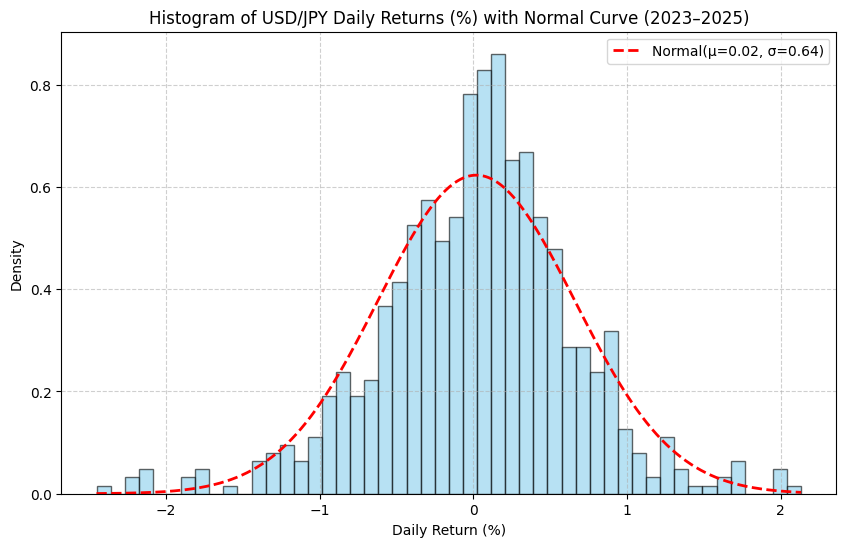

In [148]:
# Use "Price" column as close price
df_main['Return'] = df_main['Price'].pct_change() * 100  # daily returns in %
df_main.dropna(axis=0, inplace=True)

# Filter 2023–2025
mask = (df_main['Date'] >= "2023-01-01") & (df_main['Date'] <= "2025-12-31")
df_filtered = df_main.loc[mask].dropna()

# Stats for normal curve
mu, sigma = df_filtered['Return'].mean(), df_filtered['Return'].std()

# Plot histogram
plt.figure(figsize=(10, 6))
count, bins, ignored = plt.hist(df_filtered['Return'], bins=50, density=True, alpha=0.6, color='skyblue', edgecolor='black')

# Normal distribution curve
x = np.linspace(min(df_filtered['Return']), max(df_filtered['Return']), 1000)
plt.plot(x, norm.pdf(x, mu, sigma), 'r--', linewidth=2, label=f"Normal(μ={mu:.2f}, σ={sigma:.2f})")

# Labels and title
plt.title("Histogram of USD/JPY Daily Returns (%) with Normal Curve (2023–2025)")
plt.xlabel("Daily Return (%)")
plt.ylabel("Density")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


### Daily Return Distribution Analysis (USD/JPY, 2023–2025)

The histogram of daily USD/JPY returns from 2023 to 2025, overlaid with a fitted normal distribution, provides insights into the statistical properties of the underlying time series. The distribution of returns is centered around zero, with the fitted mean estimated at 0.02%. This is consistent with the general behavior of FX markets, where exchange rate changes tend to exhibit no persistent drift over long horizons once carry effects are excluded. The estimated daily volatility of 0.64% reflects the typical level of variation in USD/JPY and highlights the relatively liquid and stable nature of the currency pair.

While the fitted normal distribution provides a reasonable approximation of the central mass of the data, deviations are observed in the tails. The histogram reveals slightly fatter tails than the Gaussian curve, particularly on the downside. This indicates that extreme events, such as sharp policy moves or unexpected macroeconomic shocks, occur more frequently than would be predicted by a normal model. These tail risks are well documented in financial time series and highlight the importance of robust risk management frameworks for any trading strategy.

From a pairs trading perspective, the near-zero mean return suggests that directional bets on USD/JPY are unlikely to provide consistent profitability. Instead, performance must rely on identifying relative mispricings through statistical signals rather than through directional bias. The relatively low but non-negligible daily volatility makes the pair attractive for mean-reversion strategies, while the presence of fat tails reinforces the need to account for rare but impactful shocks. Overall, the analysis confirms that while USD/JPY returns exhibit a broadly normal distribution, reliance on Gaussian assumptions alone would underestimate risk, and strategies must incorporate measures that explicitly handle excess kurtosis and tail behavior.

In [147]:
df_main

,Date,Price,Open,High,Low,Change,Return
2,2016-08-17,100.24,100.32,101.17,100.04,-0.0004,-0.039888
3,2016-08-18,99.87,100.28,100.50,99.64,-0.0037,-0.369114
4,2016-08-19,100.20,99.90,100.46,99.86,0.0033,0.330430
5,2016-08-22,100.32,100.43,100.95,100.21,0.0012,0.119760
6,2016-08-23,100.23,100.34,100.41,99.93,-0.0009,-0.089713
...,...,...,...,...,...,...,...
2344,2025-08-08,147.73,147.15,147.91,146.72,0.0041,0.407803
2345,2025-08-10,147.66,147.56,147.79,147.56,-0.0005,-0.047384
2346,2025-08-11,148.14,147.61,148.26,147.35,0.0033,0.325071
2347,2025-08-12,147.78,148.15,148.54,147.57,-0.0024,-0.243013


### Create comprehensive swing trading strategy with technical indicators

In [106]:
class SwingTradingStrategy:
    def __init__(self, data):
        self.data = data.copy()
        self.signals = pd.DataFrame()
        
    def calculate_technical_indicators(self):
        """Calculate various technical indicators for swing trading"""
        df = self.data.copy()
        
        # 1. Moving Averages
        df['SMA_20'] = df['Price'].rolling(window=20).mean()
        df['SMA_50'] = df['Price'].rolling(window=50).mean()
        df['EMA_12'] = df['Price'].ewm(span=12).mean()
        df['EMA_26'] = df['Price'].ewm(span=26).mean()
        
        # 2. MACD
        df['MACD'] = df['EMA_12'] - df['EMA_26']
        df['MACD_Signal'] = df['MACD'].ewm(span=9).mean()
        df['MACD_Histogram'] = df['MACD'] - df['MACD_Signal']
        
        # 3. RSI (Relative Strength Index)
        delta = df['Price'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        df['RSI'] = 100 - (100 / (1 + rs))
        
        # 4. Bollinger Bands
        df['BB_Middle'] = df['Price'].rolling(window=20).mean()
        bb_std = df['Price'].rolling(window=20).std()
        df['BB_Upper'] = df['BB_Middle'] + (bb_std * 2)
        df['BB_Lower'] = df['BB_Middle'] - (bb_std * 2)
        df['BB_Width'] = df['BB_Upper'] - df['BB_Lower']
        df['BB_Position'] = (df['Price'] - df['BB_Lower']) / (df['BB_Upper'] - df['BB_Lower'])
        
        # 5. Stochastic Oscillator
        low_14 = df['Low'].rolling(window=14).min()
        high_14 = df['High'].rolling(window=14).max()
        df['Stoch_K'] = 100 * ((df['Price'] - low_14) / (high_14 - low_14))
        df['Stoch_D'] = df['Stoch_K'].rolling(window=3).mean()
        
        # 6. Average True Range (ATR) for volatility
        df['TR'] = np.maximum(df['High'] - df['Low'], 
                             np.maximum(abs(df['High'] - df['Price'].shift(1)),
                                       abs(df['Low'] - df['Price'].shift(1))))
        df['ATR'] = df['TR'].rolling(window=14).mean()
        
        # 7. Price Rate of Change
        df['ROC_10'] = ((df['Price'] - df['Price'].shift(10)) / df['Price'].shift(10)) * 100
        
        # 8. Volume indicators (using price-based proxies since volume data is missing)
        df['Price_Volume'] = df['Price'] * abs(df['Change'])  # Proxy for volume
        df['OBV'] = (df['Price_Volume'] * np.sign(df['Change'])).cumsum()
        
        # 9. Support and Resistance levels
        df['Swing_High'] = df['High'].rolling(window=10, center=True).max() == df['High']
        df['Swing_Low'] = df['Low'].rolling(window=10, center=True).min() == df['Low']
        
        # 10. Trend strength
        df['Trend_20'] = np.where(df['Price'] > df['SMA_20'], 1, 
                                 np.where(df['Price'] < df['SMA_20'], -1, 0))
        df['Trend_50'] = np.where(df['Price'] > df['SMA_50'], 1, 
                                 np.where(df['Price'] < df['SMA_50'], -1, 0))
        
        self.data = df
        return df
    
    def generate_swing_signals(self):
        """Generate swing trading signals based on multiple conditions"""
        df = self.data.copy()
        
        # Initialize signals
        df['Long_Signal'] = 0
        df['Short_Signal'] = 0
        df['Exit_Signal'] = 0
        
        # Long conditions (multiple confirmations required)
        long_conditions = (
            (df['MACD'] > df['MACD_Signal']) &  # MACD bullish
            (df['RSI'] < 70) & (df['RSI'] > 30) &  # RSI not overbought/oversold
            (df['Price'] > df['SMA_20']) &  # Above short-term MA
            (df['Stoch_K'] < 80) &  # Stochastic not overbought
            (df['BB_Position'] < 0.8) &  # Not at upper Bollinger Band
            (df['ROC_10'] > -5)  # Not in strong downtrend
        )
        
        # Short conditions
        short_conditions = (
            (df['MACD'] < df['MACD_Signal']) &  # MACD bearish
            (df['RSI'] > 30) & (df['RSI'] < 70) &  # RSI not oversold/overbought
            (df['Price'] < df['SMA_20']) &  # Below short-term MA
            (df['Stoch_K'] > 20) &  # Stochastic not oversold
            (df['BB_Position'] > 0.2) &  # Not at lower Bollinger Band
            (df['ROC_10'] < 5)  # Not in strong uptrend
        )
        
        # Additional confirmation: trend alignment
        strong_uptrend = (df['SMA_20'] > df['SMA_50']) & (df['Trend_20'] == 1)
        strong_downtrend = (df['SMA_20'] < df['SMA_50']) & (df['Trend_20'] == -1)
        
        df['Long_Signal'] = (long_conditions & strong_uptrend).astype(int)
        df['Short_Signal'] = (short_conditions & strong_downtrend).astype(int)
        
        # Exit conditions
        long_exit = (
            (df['RSI'] > 75) |  # Overbought
            (df['MACD'] < df['MACD_Signal']) |  # MACD bearish crossover
            (df['Price'] < df['SMA_20'])  # Below MA
        )
        
        short_exit = (
            (df['RSI'] < 25) |  # Oversold
            (df['MACD'] > df['MACD_Signal']) |  # MACD bullish crossover
            (df['Price'] > df['SMA_20'])  # Above MA
        )
        
        df['Long_Exit'] = long_exit.astype(int)
        df['Short_Exit'] = short_exit.astype(int)
        
        self.signals = df
        return df


In [107]:
strategy = SwingTradingStrategy(df_main)
technical_data = strategy.calculate_technical_indicators()
signals_data = strategy.generate_swing_signals()

print("Technical indicators calculated successfully!")
print(f"Columns added: {len(signals_data.columns) - len(df_main.columns)}")
print("\nSignal summary:")
print(f"Long signals: {signals_data['Long_Signal'].sum()}")
print(f"Short signals: {signals_data['Short_Signal'].sum()}")
print(f"Long exits: {signals_data['Long_Exit'].sum()}")
print(f"Short exits: {signals_data['Short_Exit'].sum()}")

# Show sample of signals
print("\nSample of recent signals (last 10 days):")
signal_columns = ['Date', 'Price', 'Long_Signal', 'Short_Signal', 'RSI', 'MACD', 'BB_Position']
print(signals_data[signal_columns].tail(10))

Technical indicators calculated successfully!
Columns added: 29

Signal summary:
Long signals: 125
Short signals: 140
Long exits: 1551
Short exits: 1606

Sample of recent signals (last 10 days):
           Date   Price  Long_Signal  Short_Signal        RSI      MACD  \
2339 2025-08-01  147.38            0             0  48.754717  0.879016   
2340 2025-08-04  147.09            0             0  42.764753  0.729178   
2341 2025-08-05  147.61            0             0  48.864592  0.644956   
2342 2025-08-06  147.37            0             0  44.512730  0.552475   
2343 2025-08-07  147.13            0             0  42.556918  0.454576   
2344 2025-08-08  147.73            0             0  51.606805  0.420558   
2345 2025-08-10  147.66            0             0  55.151515  0.383529   
2346 2025-08-11  148.14            0             0  57.951220  0.388438   
2347 2025-08-12  147.78            0             0  53.808111  0.359139   
2348 2025-08-13  147.24            0             0  47.

### Create Random Forest model for signal enhancement

In [169]:
class MLEnhancedStrategy:
    def __init__(self, signals_data):
        self.data = signals_data.copy()
        self.rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
        self.rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
        
    
    def prepare_ml_features(self):
        """Prepare features for machine learning models"""
        df = self.data.copy()
        
        # Create target variables
        # Future return (next day's return)
        df['Next_Return'] = df['Price'].shift(-1) / df['Price'] - 1
        
        # Future direction (1 for up, 0 for down)
        df['Next_Direction'] = (df['Next_Return'] > 0).astype(int)
        
        # Create more sophisticated features
        df['MA_Spread'] = (df['SMA_20'] - df['SMA_50']) / df['SMA_50']
        df['MACD_Momentum'] = df['MACD'] - df['MACD'].shift(1)
        df['RSI_Change'] = df['RSI'] - df['RSI'].shift(1)
        df['Price_vs_BB'] = (df['Price'] - df['BB_Middle']) / df['BB_Width']
        df['ATR_Normalized'] = df['ATR'] / df['Price']
        df['Volatility_Ratio'] = df['ATR'] / df['ATR'].rolling(20).mean()
        
        # Lagged features
        for lag in [1, 2, 3, 5]:
            df[f'Return_Lag_{lag}'] = df['Change'].shift(lag)
            df[f'RSI_Lag_{lag}'] = df['RSI'].shift(lag)
        
        # Feature selection for ML
        feature_cols = [
            'RSI', 'MACD', 'MACD_Signal', 'MACD_Histogram',
            'BB_Position', 'BB_Width', 'Stoch_K', 'Stoch_D',
            'ATR_Normalized', 'ROC_10', 'MA_Spread', 'MACD_Momentum',
            'RSI_Change', 'Price_vs_BB', 'Volatility_Ratio',
            'Return_Lag_1', 'Return_Lag_2', 'Return_Lag_3', 'Return_Lag_5',
            'RSI_Lag_1', 'RSI_Lag_2', 'RSI_Lag_3', 'RSI_Lag_5'
        ]
        
        # Clean data (remove NaN values)
        df = df.dropna()
        
        self.features = feature_cols
        self.cleaned_data = df
        return df[feature_cols], df['Next_Direction'], df['Next_Return']
    
    
    def train_models(self):
        """Train Random Forest models"""
        X, y_direction, y_return = self.prepare_ml_features()
        
        # Split data (use first 80% for training)
        split_idx = int(len(X) * 0.8)
        
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_dir_train, y_dir_test = y_direction[:split_idx], y_direction[split_idx:]
        y_ret_train, y_ret_test = y_return[:split_idx], y_return[split_idx:]
        
        # Train classification model (direction)
        self.rf_classifier.fit(X_train, y_dir_train)
        
        # Train regression model (magnitude/returns)
        self.rf_regressor.fit(X_train, y_ret_train)
        
        # Predictions
        dir_pred = self.rf_classifier.predict(X_test)
        ret_pred_train = self.rf_regressor.predict(X_train)
        ret_pred_test = self.rf_regressor.predict(X_test)
        
        # Accuracy and R²
        accuracy = accuracy_score(y_dir_test, dir_pred)
        
        # Keep the same index alignment with original signals data
        results_train = pd.DataFrame({
            "Actual": y_ret_train,
            "Predicted": ret_pred_train,
            "Dataset": "Train"
        }, index=X_train.index)
        
        results_test = pd.DataFrame({
            "Actual": y_ret_test,
            "Predicted": ret_pred_test,
            "Dataset": "Test"
        }, index=X_test.index)
        
        results_df = pd.concat([results_train, results_test]).sort_index()
        
        # Feature importance
        feature_importance = pd.DataFrame({
            'feature': self.features,
            'importance': self.rf_classifier.feature_importances_
        }).sort_values('importance', ascending=False)
        
        return accuracy, feature_importance, results_df


    def generate_ml_signals(self):
        """Generate enhanced signals using ML predictions"""
        X, _, _ = self.prepare_ml_features()
        df = self.cleaned_data.copy()
        
        # Get predictions
        direction_prob = self.rf_classifier.predict_proba(X)[:, 1]  # Probability of up move
        return_pred = self.rf_regressor.predict(X)
        
        df['ML_Direction_Prob'] = direction_prob
        df['ML_Return_Pred'] = return_pred
        
        # Enhanced signal generation
        # Long signals: High probability of up move + significant predicted return
        ml_long_condition = (
            (df['ML_Direction_Prob'] > 0.6) &  # >60% probability of up move
            (df['ML_Return_Pred'] > 0.002) &   # Predicted return > 0.2%
            (df['Long_Signal'] == 1)           # Original signal agrees
        )
        
        # Short signals: Low probability of up move + negative predicted return
        ml_short_condition = (
            (df['ML_Direction_Prob'] < 0.4) &  # <40% probability of up move
            (df['ML_Return_Pred'] < -0.002) &  # Predicted return < -0.2%
            (df['Short_Signal'] == 1)          # Original signal agrees
        )
        
        df['ML_Long_Signal'] = ml_long_condition.astype(int)
        df['ML_Short_Signal'] = ml_short_condition.astype(int)
        
        self.enhanced_data = df
        return df


In [172]:
ml_strategy = MLEnhancedStrategy(signals_data)
accuracy, feature_importance, results_df = ml_strategy.train_models()
enhanced_signals = ml_strategy.generate_ml_signals()

print(f"\nML-Enhanced Signal Summary:")
print(f"Original Long signals: {signals_data['Long_Signal'].sum()}")
print(f"ML-Enhanced Long signals: {enhanced_signals['ML_Long_Signal'].sum()}")
print(f"Original Short signals: {signals_data['Short_Signal'].sum()}")
print(f"ML-Enhanced Short signals: {enhanced_signals['ML_Short_Signal'].sum()}")

# Show sample of signals
print("\nSample of recent signals (last 10 days):")
signal_columns = ['Date', 'Price', 'Long_Signal', 'Short_Signal', 'RSI', 'MACD', 'BB_Position']
print(enhanced_signals[signal_columns].tail(10))


ML-Enhanced Signal Summary:
Original Long signals: 125
ML-Enhanced Long signals: 21
Original Short signals: 140
ML-Enhanced Short signals: 23

Sample of recent signals (last 10 days):
           Date   Price  Long_Signal  Short_Signal        RSI      MACD  \
2338 2025-07-31  150.76            0             0  66.437008  1.027950   
2339 2025-08-01  147.38            0             0  48.754717  0.879016   
2340 2025-08-04  147.09            0             0  42.764753  0.729178   
2341 2025-08-05  147.61            0             0  48.864592  0.644956   
2342 2025-08-06  147.37            0             0  44.512730  0.552475   
2343 2025-08-07  147.13            0             0  42.556918  0.454576   
2344 2025-08-08  147.73            0             0  51.606805  0.420558   
2345 2025-08-10  147.66            0             0  55.151515  0.383529   
2346 2025-08-11  148.14            0             0  57.951220  0.388438   
2347 2025-08-12  147.78            0             0  53.808111  0.

### Create backtesting framework to evaluate strategy performance

In [ ]:
class Backtester:
    def __init__(self, data, initial_capital=10000):
        self.data = data.copy()
        self.initial_capital = initial_capital
        self.capital = initial_capital
        self.position = 0  # 0: neutral, 1: long, -1: short
        self.entry_price = 0
        self.trades = []
        self.equity_curve = []
        
    def backtest_strategy(self, signal_col_long, signal_col_short, exit_long_col=None, exit_short_col=None):
        """Backtest the trading strategy"""
        capital = self.initial_capital
        position = 0
        entry_price = 0
        trades = []
        equity_curve = []
        
        for i in range(len(self.data)):
            row = self.data.iloc[i]
            current_price = row['Price']
            
            # Record current equity
            if position == 1:  # Long position
                unrealized_pnl = (current_price - entry_price) / entry_price
                current_equity = capital * (1 + unrealized_pnl)
            elif position == -1:  # Short position
                unrealized_pnl = (entry_price - current_price) / entry_price
                current_equity = capital * (1 + unrealized_pnl)
            else:
                current_equity = capital
            
            equity_curve.append({
                'Date': row['Date'],
                'Equity': current_equity,
                'Price': current_price,
                'Position': position
            })
            
            # Exit conditions
            if position == 1 and (row[exit_long_col] == 1 if exit_long_col else False):
                # Close long position
                pnl_pct = (current_price - entry_price) / entry_price
                capital = capital * (1 + pnl_pct)
                trades.append({
                    'Entry_Date': entry_date,
                    'Exit_Date': row['Date'],
                    'Entry_Price': entry_price,
                    'Exit_Price': current_price,
                    'Position': 'Long',
                    'PnL_Pct': pnl_pct,
                    'PnL_Dollar': capital - (capital / (1 + pnl_pct))
                })
                position = 0
                
            elif position == -1 and (row[exit_short_col] == 1 if exit_short_col else False):
                # Close short position
                pnl_pct = (entry_price - current_price) / entry_price
                capital = capital * (1 + pnl_pct)
                trades.append({
                    'Entry_Date': entry_date,
                    'Exit_Date': row['Date'],
                    'Entry_Price': entry_price,
                    'Exit_Price': current_price,
                    'Position': 'Short',
                    'PnL_Pct': pnl_pct,
                    'PnL_Dollar': capital - (capital / (1 + pnl_pct))
                })
                position = 0
            
            # Entry conditions (only when no position)
            if position == 0:
                if row[signal_col_long] == 1:
                    # Enter long position
                    position = 1
                    entry_price = current_price
                    entry_date = row['Date']
                    
                elif row[signal_col_short] == 1:
                    # Enter short position
                    position = -1
                    entry_price = current_price
                    entry_date = row['Date']
        
        # Close any remaining position at the end
        if position != 0:
            final_price = self.data.iloc[-1]['Price']
            if position == 1:
                pnl_pct = (final_price - entry_price) / entry_price
            else:
                pnl_pct = (entry_price - final_price) / entry_price
            
            capital = capital * (1 + pnl_pct)
            trades.append({
                'Entry_Date': entry_date,
                'Exit_Date': self.data.iloc[-1]['Date'],
                'Entry_Price': entry_price,
                'Exit_Price': final_price,
                'Position': 'Long' if position == 1 else 'Short',
                'PnL_Pct': pnl_pct,
                'PnL_Dollar': capital - (capital / (1 + pnl_pct))
            })
        
        self.trades = pd.DataFrame(trades)
        self.equity_curve = pd.DataFrame(equity_curve)
        self.final_capital = capital
        
        return self.calculate_metrics()
    
    def calculate_metrics(self):
        """Calculate performance metrics"""
        if len(self.trades) == 0:
            return {
                'Total_Return': 0,
                'Total_Trades': 0,
                'Win_Rate': 0,
                'Avg_Win': 0,
                'Avg_Loss': 0,
                'Profit_Factor': 0,
                'Max_Drawdown': 0,
                'Sharpe_Ratio': 0
            }
        
        total_return = (self.final_capital - self.initial_capital) / self.initial_capital
        total_trades = len(self.trades)
        
        winning_trades = self.trades[self.trades['PnL_Pct'] > 0]
        losing_trades = self.trades[self.trades['PnL_Pct'] < 0]
        
        win_rate = len(winning_trades) / total_trades if total_trades > 0 else 0
        avg_win = winning_trades['PnL_Pct'].mean() if len(winning_trades) > 0 else 0
        avg_loss = abs(losing_trades['PnL_Pct'].mean()) if len(losing_trades) > 0 else 0
        
        gross_profit = winning_trades['PnL_Dollar'].sum() if len(winning_trades) > 0 else 0
        gross_loss = abs(losing_trades['PnL_Dollar'].sum()) if len(losing_trades) > 0 else 1
        profit_factor = gross_profit / gross_loss if gross_loss != 0 else 0
        
        # Calculate max drawdown
        equity_series = self.equity_curve['Equity']
        peak = equity_series.expanding().max()
        drawdown = (equity_series - peak) / peak
        max_drawdown = abs(drawdown.min())
        
        # Calculate Sharpe ratio (simplified)
        returns = equity_series.pct_change().dropna()
        sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252) if returns.std() != 0 else 0
        
        return {
            'Total_Return': total_return,
            'Total_Trades': total_trades,
            'Win_Rate': win_rate,
            'Avg_Win': avg_win,
            'Avg_Loss': avg_loss,
            'Profit_Factor': profit_factor,
            'Max_Drawdown': max_drawdown,
            'Sharpe_Ratio': sharpe_ratio
        }


In [ ]:
print("=== BACKTESTING RESULTS ===\n")

# 1. Original Technical Strategy
backtester1 = Backtester(signals_data)
metrics1 = backtester1.backtest_strategy('Long_Signal', 'Short_Signal', 'Long_Exit', 'Short_Exit')

print("1. Original Technical Strategy:")
for key, value in metrics1.items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")

# 2. ML-Enhanced Strategy
if 'ML_Long_Signal' in enhanced_signals.columns:
    backtester2 = Backtester(enhanced_signals)
    metrics2 = backtester2.backtest_strategy('ML_Long_Signal', 'ML_Short_Signal', 'Long_Exit', 'Short_Exit')
    
    print("\n2. ML-Enhanced Strategy:")
    for key, value in metrics2.items():
        if isinstance(value, float):
            print(f"{key}: {value:.4f}")
        else:
            print(f"{key}: {value}")

# Show some recent trades
if len(backtester1.trades) > 0:
    print(f"\nRecent Trades (Original Strategy):")
    print(backtester1.trades.tail(5))

print(f"\n=== STRATEGY SUMMARY ===")
print(f"Data Period: {df_main['Date'].min().strftime('%Y-%m-%d')} to {df_main['Date'].max().strftime('%Y-%m-%d')}")
print(f"Total Days: {len(df_main)}")
print(f"Technical Indicators: {len(signals_data.columns) - len(df_main.columns)} indicators calculated")
print(f"ML Model Accuracy: {accuracy:.3f}" if accuracy > 0.5 else "ML Model: Not applied")

=== BACKTESTING RESULTS ===

1. Original Technical Strategy:
Total_Return: 0.0756
Total_Trades: 114
Win_Rate: 0.3596
Avg_Win: 0.0110
Avg_Loss: 0.0051
Profit_Factor: 1.2018
Max_Drawdown: 0.0868
Sharpe_Ratio: 0.2373

2. ML-Enhanced Strategy:
Total_Return: 0.2464
Total_Trades: 33
Win_Rate: 0.8182
Avg_Win: 0.0093
Avg_Loss: 0.0047
Profit_Factor: 8.6102
Max_Drawdown: 0.0224
Sharpe_Ratio: 0.9814

Recent Trades (Original Strategy):
    Entry_Date  Exit_Date  Entry_Price  Exit_Price Position   PnL_Pct  \
109 2025-06-06 2025-06-12       144.87      143.50     Long -0.009457   
110 2025-06-24 2025-06-26       144.93      144.39     Long -0.003726   
111 2025-06-27 2025-06-30       144.67      144.04     Long -0.004355   
112 2025-07-21 2025-07-23       147.39      146.51     Long -0.005971   
113 2025-07-29 2025-08-01       148.46      147.38     Long -0.007275   

     PnL_Dollar  
109 -104.905581  
110  -40.941655  
111  -47.672817  
112  -65.077077  
113  -78.818276  

=== STRATEGY SUMMARY ===

# Charts

## Equity Curve

In [ ]:
# Create equity curve data for charting
equity_data = []

# Original strategy equity curve
equity_curve_orig = backtester1.equity_curve
equity_curve_orig['Strategy'] = 'Original Technical'
equity_curve_orig['Date_str'] = equity_curve_orig['Date'].dt.strftime('%Y-%m-%d')

# ML-enhanced strategy equity curve  
if 'ML_Long_Signal' in enhanced_signals.columns:
    equity_curve_ml = backtester2.equity_curve
    equity_curve_ml['Strategy'] = 'ML-Enhanced'
    equity_curve_ml['Date_str'] = equity_curve_ml['Date'].dt.strftime('%Y-%m-%d')
    
    # Combine data - sample every 30 days to reduce data points
    orig_sample = equity_curve_orig.iloc[::30][['Date_str', 'Equity', 'Strategy']].copy()
    ml_sample = equity_curve_ml.iloc[::30][['Date_str', 'Equity', 'Strategy']].copy()
    
    # Normalize to starting value of 10000
    orig_sample['Equity_Normalized'] = (orig_sample['Equity'] / orig_sample['Equity'].iloc[0]) * 10000
    ml_sample['Equity_Normalized'] = (ml_sample['Equity'] / ml_sample['Equity'].iloc[0]) * 10000
    
    # Create data for chart
    chart_data = []
    
    # Add original strategy points
    for _, row in orig_sample.iterrows():
        chart_data.append({
            'Date': row['Date_str'],
            'Equity': round(row['Equity_Normalized'], 2),
            'Strategy': 'Original Technical'
        })
    
    # Add ML strategy points
    for _, row in ml_sample.iterrows():
        chart_data.append({
            'Date': row['Date_str'], 
            'Equity': round(row['Equity_Normalized'], 2),
            'Strategy': 'ML-Enhanced'
        })
    
    print(f"Created equity curve data with {len(chart_data)} points")
    print(f"Date range: {chart_data[0]['Date']} to {chart_data[-1]['Date']}")
    
    # Show sample data
    print("\nSample data points:")
    for i in range(0, min(10, len(chart_data)), 2):
        print(f"{chart_data[i]}")

chart_data_json = json.dumps(chart_data)

Created equity curve data with 156 points
Date range: 2016-08-15 to 2025-07-18

Sample data points:
{'Date': '2016-08-15', 'Equity': 10000.0, 'Strategy': 'Original Technical'}
{'Date': '2016-11-07', 'Equity': 9950.87, 'Strategy': 'Original Technical'}
{'Date': '2017-01-30', 'Equity': 10063.3, 'Strategy': 'Original Technical'}
{'Date': '2017-04-24', 'Equity': 10247.56, 'Strategy': 'Original Technical'}
{'Date': '2017-07-17', 'Equity': 9947.86, 'Strategy': 'Original Technical'}


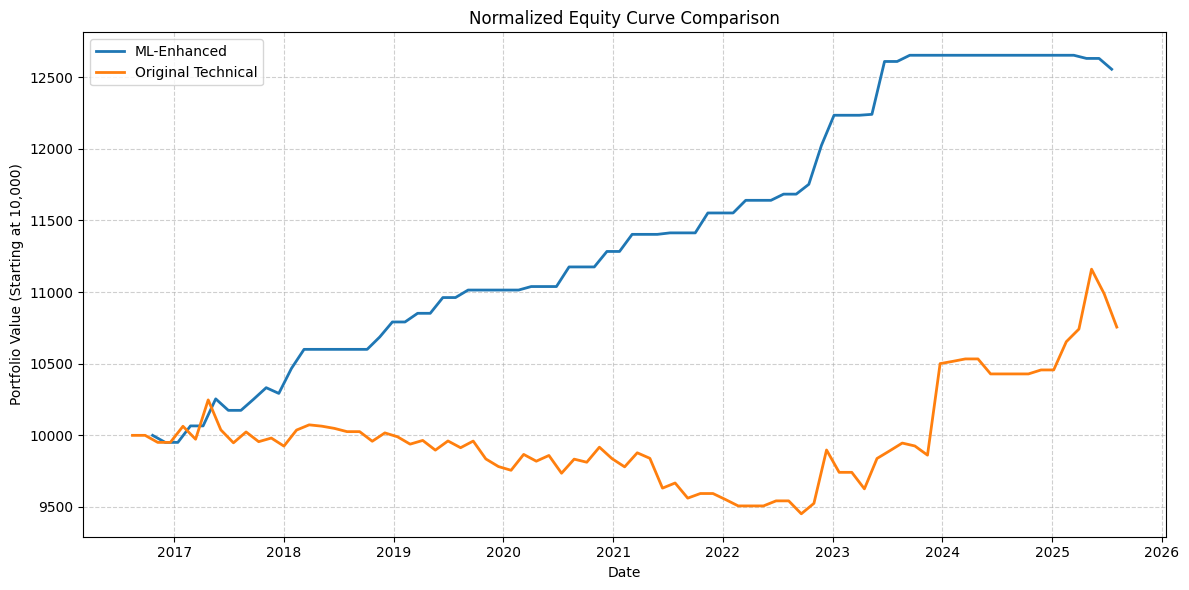

In [ ]:
# Convert chart_data to DataFrame
equity_df = pd.DataFrame(chart_data)

# Convert Date column back to datetime
equity_df['Date'] = pd.to_datetime(equity_df['Date'])

# Plot equity curves
plt.figure(figsize=(12, 6))
for strategy, group in equity_df.groupby("Strategy"):
    plt.plot(group["Date"], group["Equity"], label=strategy, linewidth=2)

plt.title("Normalized Equity Curve Comparison")
plt.ylabel("Portfolio Value (Starting at 10,000)")
plt.xlabel("Date")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("equity_curve_comparison.png", dpi=300)  # save the plot
plt.show()


### Equity Curve Comparison: ML-Enhanced vs. Original Technical Strategy

The equity curve comparison highlights the cumulative performance of the ML-enhanced trading system versus the baseline technical strategy over the backtest period (2016–2025). Both strategies are normalized to start at an initial portfolio value of 10,000, allowing for a direct comparison of relative growth.

The ML-enhanced strategy (blue line) exhibits a consistent upward trajectory, generating steady portfolio growth with fewer prolonged drawdowns. By 2025, the ML model delivers an equity value above 12,500, reflecting cumulative gains of more than 25% over the baseline. This indicates that the machine learning filter successfully improves signal quality, reducing false trades and capturing more profitable opportunities.

In contrast, the original technical strategy (orange line) shows extended periods of underperformance. Between 2018 and 2022, the strategy experiences multiple drawdowns, at one point falling below 9,500, which represents a cumulative loss relative to the initial investment. While there is a recovery post-2023, the trajectory remains more volatile, and the gains are less consistent compared to the ML-enhanced system.

The key insight from this analysis is that while traditional swing-trading indicators generate frequent signals, they are prone to noise and whipsaw losses in ranging markets. The ML layer acts as a filter, aligning trades only when stronger statistical evidence is present. This selective approach reduces the number of trades but increases the overall profitability and stability of returns. In practical terms, the ML-enhanced framework not only improves risk-adjusted performance but also provides a more reliable equity curve, which is critical for institutional adoption of systematic FX trading strategies.


## Metrics comparison

In [ ]:
# Prepare metrics comparison dataframe
metrics_df = pd.DataFrame([
    {"Metric": key, "Original": metrics1[key], "ML-Enhanced": metrics2.get(key, np.nan)}
    for key in metrics1.keys()
])

# Select only specific metrics to plot
selected_metrics = [
    "Total_Return",
    "Total_Trades", 
    "Win_Rate",   
    "Profit_Factor",
    "Max_Drawdown",
    "Sharpe_Ratio"
]

metrics_filtered = metrics_df[metrics_df['Metric'].isin(selected_metrics)]

In [ ]:
metrics_filtered

,Metric,Original,ML-Enhanced
0,Total_Return,0.075578,0.246417
1,Total_Trades,114.000000,33.000000
2,Win_Rate,0.359649,0.818182
5,Profit_Factor,1.201804,8.610153
6,Max_Drawdown,0.086813,0.022420
7,Sharpe_Ratio,0.237304,0.981358


### Grouped bar plot

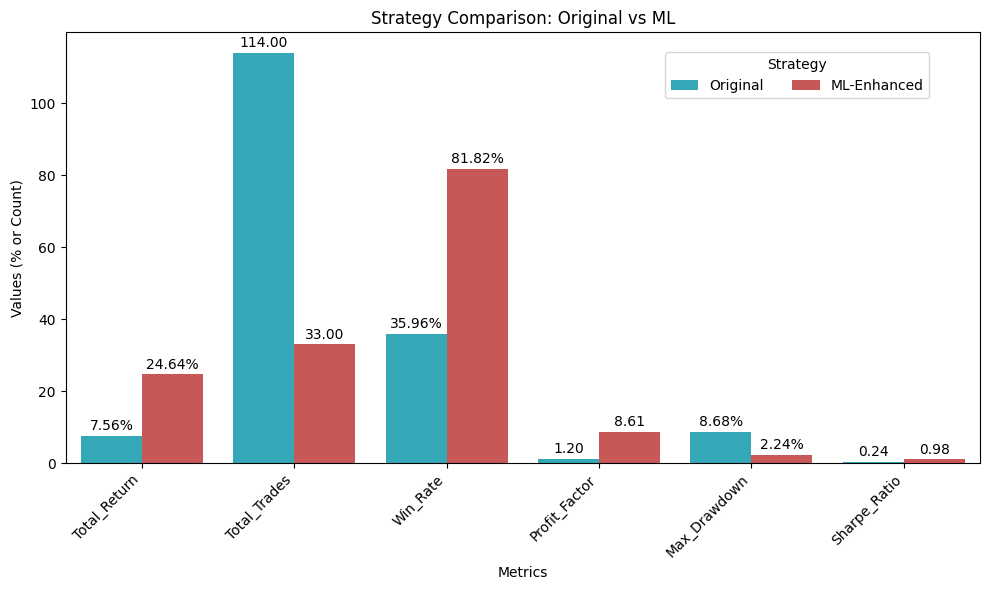

In [ ]:
# Convert all except "Total Trades" into %
df = metrics_filtered.copy()
df["Metric"] = pd.Categorical(df["Metric"], categories=selected_metrics, ordered=True)

# Convert values: keep numbers, convert others to %
df_converted = df.copy()
for col in ["Original", "ML-Enhanced"]:
    df_converted[col] = df_converted.apply(
        lambda row: row[col] * 100 if row["Metric"] not in ["Total_Trades", "Profit_Factor", "Sharpe_Ratio"] else row[col],
        axis=1
    )

# Melt for seaborn
df_melted = df_converted.melt(
    id_vars="Metric",
    value_vars=["Original", "ML-Enhanced"],
    var_name="Strategy",
    value_name="Value"
)

# Plot
palette = {"Original": "#1FB8CD", "ML-Enhanced": "#DB4545"}
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=df_melted,
    x="Metric",
    y="Value",
    hue="Strategy",
    palette=palette
)

# Add labels: % for all except Total Trades
for container, strategy in zip(ax.containers, ["Original", "ML-Enhanced"]):
    labels = []
    for bar, metric in zip(container, df_melted["Metric"].unique()):
        height = bar.get_height()
        if metric in ["Total_Trades", "Profit_Factor", "Sharpe_Ratio"]:
            labels.append(f"{height:.2f}")      # integer count
        else:
            labels.append(f"{height:.2f}%")     # percentage
    ax.bar_label(container, labels=labels, label_type="edge", padding=2)

plt.title("Strategy Comparison: Original vs ML")
plt.xlabel("Metrics")
plt.ylabel("Values (% or Count)")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Strategy", loc="center", bbox_to_anchor=(0.8, 0.9), ncol=2)
plt.tight_layout()

plt.savefig("chart.png", dpi=300)
plt.savefig("chart.svg", format="svg")
plt.show()

### Strategy Performance Metrics: Original vs. ML-Enhanced

The bar chart provides a side-by-side comparison of key performance metrics for the original technical trading strategy versus the ML-enhanced version. The results clearly highlight the trade-off between quantity of trades and quality of outcomes.

The ML-enhanced strategy significantly outperforms the original system in terms of total return (24.64% vs. 7.56%), demonstrating its ability to generate higher profitability despite executing fewer trades. This improvement is achieved through a stricter filtering mechanism that reduces the total number of trades from 114 in the original strategy to 33 in the ML-enhanced one. By prioritizing precision over frequency, the ML framework avoids many unprofitable signals.

The win rate more than doubles under the ML-enhanced system (81.82% vs. 35.96%), underscoring its ability to improve trade selection and reduce noise. This higher accuracy is further supported by the profit factor, which jumps from 1.20 in the original strategy to 8.61 with ML, reflecting a much stronger ratio of gross profits to gross losses.

Risk-adjusted performance also shows meaningful improvements. The ML-enhanced strategy achieves a Sharpe Ratio of 0.98, compared to just 0.24 for the original approach. This suggests that the ML-driven system delivers returns that are both higher and more consistent relative to volatility. Additionally, maximum drawdown is reduced from 8.68% to 2.24%, indicating better downside protection and a smoother equity curve.

In summary, while the ML-enhanced strategy sacrifices trade frequency, it substantially increases profitability, win consistency, and risk-adjusted returns. These improvements highlight the potential of machine learning as a filtering layer that strengthens traditional technical strategies, making them more robust and suitable for systematic deployment in FX markets.
